<a href="https://colab.research.google.com/github/agpascoe/NN_experiments/blob/main/Pytorch/WINE_Correlation_ResidualSugar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Find missing data in wine experiment
## Sept 2022

This model uses the wine dataset of: "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

it uses the folowwing artifacts:

**def splitData(partitions, batch_size, data, labels, verbose=False):**
This function splits the data and create dataloaders ready for the model. Partitions is an array of two % [80%,10%] for example, where the first is for trainning, then for validation and the rest for testing in this case 10%.

**class regressionNet(nn.Module):** where we encapsulate the whole regression model.

    **def __init__(self, nImputs, nOutputs, hidden, nHidden, dr=0.0):** this construrctor permits a variable construction of the NN in terms of Hidden Layers amd nodes in each.
    
    **def nCopy(self, n):** permits create a copy of this NN to another.
    **def forward(self,x):**
    **def testModel(self, n, test_loader, precision=0.1):** permits to test the model using a x imput vector
    **def fit(self, train_loader, dev_loader, numepochs = 100, learningRate=0.01, weight_decay=0.1, precision=0.1, initializer='kaiming'):** trainning algorithm with a lot of customization parameters.
    **def drawModel(self, figsize=(15,18)):** to draw the model with an extense set of graphs, including weight behaviour.

Finally, we ran an experiment, where we are running the model with three variables: HIDDEN as number of Hidden layers, NHIDDEN as number of nodes in those Hidden Layers and in case needed, repeating each one of this cases n times just for review results consistency precision is a parameter used for accuracy matters to define how near we are getting the prediction.


In [86]:
# Note: this code has used part of DUDL_metaparams_multioutput.ipynb (section "Metaparameters")

In [87]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Subset,SubsetRandomSampler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import copy

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

#display.set_matplotlib_formats('svg')

# Download and inspect the data

In [88]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')

print(data.describe())


       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

In [89]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


#Data Dictionary:
##1 - fixed acidity
##2 - volatile acidity
##3 - citric acid
##4 - residual sugar
##5 - chlorides
##6 - free sulfur dioxide
##7 - total sulfur dioxide
##8 - density
##9 - pH
##10 - sulphates
##11 - alcohol
##Output variable (based on sensory data):
##12 - quality (score between 0 and 10)

# So the experiment is about to predict residual sugar (field4) from the other values. Is like a Correlation kind of problem



In [90]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

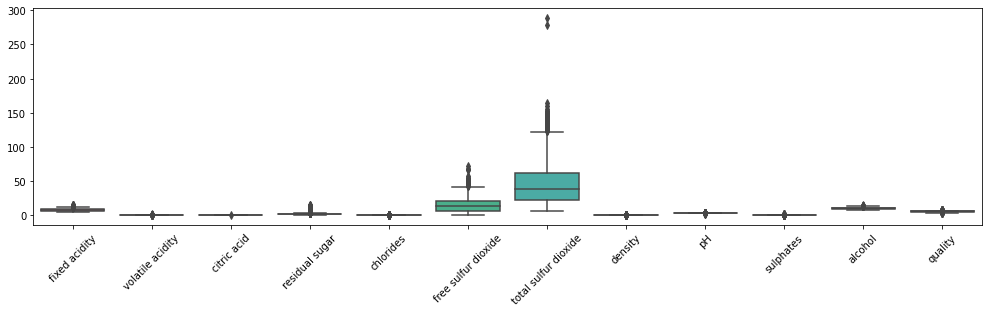

In [91]:
# check the distributions
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [92]:
# lets avoid outliers
not_outliers= (data['total sulfur dioxide']<150) & (data['residual sugar']<14)
len(data[not_outliers])

1587

In [93]:
data = copy.deepcopy(data[not_outliers])


In [94]:
#normalizing all the array, except label

for i in range(12):
  #data[i]= (data[i]-data[i].mean())/data[i].std()
  if i!= 3:
    data.iloc[:,i]= (data.iloc[:,i]-data.iloc[:,i].mean())/data.iloc[:,i].std()


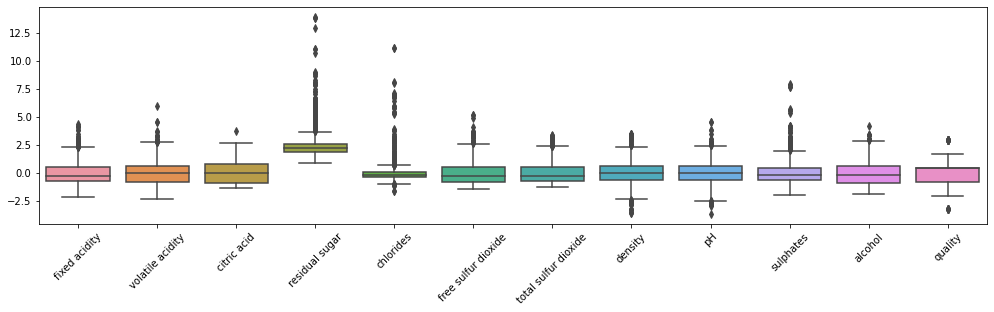

In [95]:
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [96]:
data = data[(data['chlorides']<5) & (data['sulphates']<5)] #elimminating more outlayers

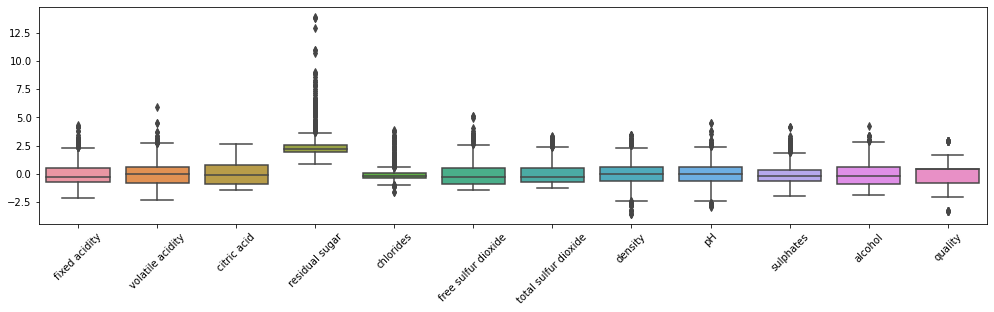

In [97]:
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [98]:

#moving residual sugar to the first column
#NOT NEEDED BUT FUNNY TO GET
labels = data.pop('residual sugar')
data.insert(0,"label", labels)
data

,label,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.9,-0.526053,0.972143,-1.385761,-0.241572,-0.460030,-0.375175,0.573758,1.283197,-0.579320,-0.963006,-0.786853
1,2.6,-0.296463,1.985970,-1.385761,0.226685,0.911817,0.688217,0.035055,-0.725312,0.128804,-0.587008,-0.786853
2,2.3,-0.296463,1.310085,-1.180338,0.098978,-0.068074,0.269305,0.142795,-0.336568,-0.048227,-0.587008,-0.786853
3,1.9,1.655051,-1.393453,1.490155,-0.262856,0.127904,0.462649,0.681499,-0.984474,-0.461299,-0.587008,0.450744
4,1.9,-0.526053,0.972143,-1.385761,-0.241572,-0.460030,-0.375175,0.573758,1.283197,-0.579320,-0.963006,-0.786853
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,2.0,-1.214823,0.408906,-0.974916,0.056410,1.597741,-0.052935,-0.988482,0.894453,-0.461299,0.070988,-0.786853
1595,2.2,-1.387015,0.127287,-0.872204,-0.539553,2.283664,0.172633,-0.869967,1.347988,0.600886,0.728985,0.450744
1596,2.3,-1.157425,-0.098008,-0.718137,-0.241572,1.303773,-0.181831,-0.535971,0.700082,0.541876,0.540986,0.450744
1597,2.0,-1.387015,0.662363,-0.769493,-0.262856,1.597741,-0.052935,-0.681421,1.671941,0.305835,-0.211010,-0.786853


In [99]:
#Get a sample of 100
#NOT NEEDED BUT FUNNY TO GET
sampleForEstimate = 100
data.iloc[list(pd.array(np.random.randint(0,data.shape[0],sampleForEstimate)))]




,label,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
407,3.0,2.114231,-0.773892,2.003711,0.120263,-0.362041,-0.504071,1.543425,-0.854893,-0.166248,0.352987,1.688341
1414,2.2,0.966281,-1.168158,1.644222,-0.220287,-1.243943,-0.987431,1.435684,-0.725312,0.718907,-0.775007,-0.786853
1294,2.1,-0.066873,0.606039,-0.872204,-0.305425,0.911817,0.462649,-0.191201,-0.142196,0.541876,0.446986,0.450744
500,1.9,-0.296463,-0.041684,-0.101870,-0.135150,-0.166063,-0.246279,0.896980,0.764872,-0.048227,-1.339005,0.450744
165,1.7,-0.296463,0.577877,1.079310,0.269254,-0.166063,1.622713,-0.342038,-0.790103,-0.225258,-0.869007,-0.786853
...,...,...,...,...,...,...,...,...,...,...,...,...
131,2.3,-1.559208,-0.154331,-0.923560,-0.816251,0.127904,1.719385,-1.634926,2.060684,-0.166248,2.420976,-0.786853
1097,1.5,0.162717,-0.041684,0.565753,0.184116,-1.047964,-0.890759,-0.040364,-0.725312,-0.815361,-0.963006,-0.786853
931,2.0,-0.526053,0.465230,-1.334405,-0.284141,-0.264052,-0.246279,0.401373,1.088825,-0.048227,-0.587008,-0.786853
583,1.9,2.114231,-1.393453,1.130665,-0.284141,-0.558019,-0.794087,0.466018,-2.150705,0.010783,-0.493009,1.688341


In [100]:
#creating vector of labels
labels = np.array(data["label"])
labels = labels[:,None] #in correlation experiments, need to form an array of (n,1) for loss function
print(labels[:5],labels.shape)



[[1.9]
 [2.6]
 [2.3]
 [1.9]
 [1.9]] (1560, 1)


In [101]:
#creating matrix of x
data = np.array(data.iloc[:,1:])
print(data[:5],data.shape)

[[-0.52605312  0.97214315 -1.38576073 -0.24157185 -0.46003002 -0.3751751
   0.57375833  1.28319707 -0.57931987 -0.96300644 -0.78685279]
 [-0.29646321  1.98597011 -1.38576073  0.22668484  0.9118171   0.68821696
   0.03505477 -0.72531193  0.12880385 -0.58700835 -0.78685279]
 [-0.29646321  1.31008547 -1.1803382   0.09897847 -0.0680737   0.26930494
   0.14279548 -0.33656825 -0.04822708 -0.58700835 -0.78685279]
 [ 1.65505099 -1.3934531   1.49015473 -0.26285624  0.12790446  0.46264895
   0.68149904 -0.98447438 -0.46129925 -0.58700835  0.45074421]
 [-0.52605312  0.97214315 -1.38576073 -0.24157185 -0.46003002 -0.3751751
   0.57375833  1.28319707 -0.57931987 -0.96300644 -0.78685279]] (1560, 11)


In [102]:
#this function splits the data and create dataloaders ready for the model
def splitData(partitions, batch_size, data, labels, verbose=False):

  # partitions =[%trainning, %test]
  # split the data
  data = torch.tensor(data).float()
  labels = torch.tensor(labels).float()

  train_data,devtest_data, train_labels,devtest_labels = train_test_split(data, labels, train_size=partitions[0],shuffle=True)#randomized

  # now split the devtest data
  dev_data,test_data, dev_labels,test_labels = train_test_split(devtest_data, devtest_labels, train_size=partitions[1]/(1-partitions[0]),shuffle=True)
  
  # print out the sizes
  if verbose:
    print('   Total data size: ' + str(data.shape) + '\n')
    print('Training data size: ' + str(train_data.shape))
    print('Trainning Label data size: ' + str(train_labels.shape))
    print('Dev data size: ' + str(dev_data.shape))
    print('Dev Label data size: ' + str(dev_labels.shape))
    print('Dev test size: ' + str(test_data.shape))
    print('Dev test data size: ' + str(test_labels.shape))

  # then convert them into PyTorch Datasets (note: already converted to tensors)
  train_data = TensorDataset(train_data, train_labels)
  dev_data   = TensorDataset(dev_data,dev_labels)
  test_data  = TensorDataset(test_data,test_labels)
 
 
  # finally, translate into dataloader objects
  train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
  dev_loader   = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

  return(train_loader, dev_loader, test_loader)


# Create and validate the model

In [103]:
# I implemented this model a a whole class.. trainning and other functions are methods of the model.
# Also this class is fully parametrized about layers and nodes

class regressionNet(nn.Module):
    def __init__(self, nImputs, nOutputs, hidden, nHidden, dr=0.0):
      super().__init__()

      #Create a dictionary to save the layers
      self.layers = nn.ModuleDict()
      self.nImputs = nImputs
      self.nOutputs = nOutputs
      self.nHidden = nHidden
      self.hidden = hidden
      self.dr = dr #Dropuot rate

      self.trainAcc = [] #for storing the accuracy vectors of trainning and dev
      self.devAcc = []
      self.losses = [] #for storing losses at trainning

      #This two vectors are for measure weight changes and withconds of the learnig process
      self.weightChanges = [] #This counts about how much is learning in each epoch
      self.weightConds = [] #this how much is specializing in anykind of particularlity
      
      ### input layer
      self.layers["input"] = nn.Linear(nImputs,nHidden)

      for h in range(self.hidden):      
      ### hidden layer
        self.layers[f'hidden{h}'] = nn.Linear(nHidden,nHidden)

      ### output layer
      self.layers['output'] = nn.Linear(nHidden,nOutputs)

    def nCopy(self, n):
      self.load_state_dict(n['net'])

    # forward pass
    def forward(self,x):
      x = F.leaky_relu( self.layers['input'](x) )
      x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
   
      for h in range(self.hidden):
        x = F.leaky_relu( self.layers[f'hidden{h}'](x) )
        x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
      return self.layers['output'](x)

   
    def testModel(self, n, test_loader, precision=0.1):
      # extract X,y from test dataloader
      X,y = next(iter(test_loader)) 
      self.load_state_dict(n['net'])
      self.eval()
      yHat = self.forward(X)
  
      bestAcc =  100*torch.mean((torch.abs((yHat-y)**2)<precision).float())
      return(yHat, bestAcc)


    def fit(self, train_loader, dev_loader, numepochs = 100, learningRate=0.01, weight_decay=0.1, precision=0.1, initializer='kaiming'):
      # New! initialize a dictionary for the best model
      
      self.weightChanges = np.zeros((numepochs, self.hidden+2)) #This two vectors are for measure weight changes and withconds of the learnig process
      self.weightConds = np.zeros((numepochs, self.hidden+2))
      
      theBestModel = {'devAccuracy':0, 'net':None, 'epoch':0} #net will be the whole model instance

      if initializer == 'xavier':         #this set the methgod for iniatiazing weights
        for p in self.named_parameters():
          if 'weight' in p[0]:
            nn.init.xavier_normal_(p[1].data)
      else:
        for p in self.named_parameters():
          if 'weight' in p[0]:
            nn.init.kaiming_uniform_(p[1].data, nonlinearity='leaky_relu') #be sure that relu or leaky_relu is the activation

      # loss function
      self.lossfun = nn.MSELoss()

      # optimizer
      self.optimizer = torch.optim.AdamW(self.parameters(), lr=learningRate, weight_decay=weight_decay, )


      # initialize losses
      self.losses   = torch.zeros(numepochs)

      # loop over epochs
      for epochi in range(numepochs):

        # store the weights for each layer
        preW = []
        for p in self.named_parameters():
          if 'weight' in p[0]:
            preW.append( copy.deepcopy(p[1].data.numpy()) )


        # switch on training mode
        self.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []

        for X,y in train_loader: #each time that runs in EACH epoch, suffle ALL the samples in each bactch
     
          # forward pass and loss
          yHat = self.forward(X)
      
          loss = self.lossfun(yHat,y) #Use in case of BCEWithLogitsLoss()

          # backprop
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          # loss from this batch
          batchLoss.append(loss.item())

          # compute accuracy
 
          matches = (torch.abs((yHat-y)**2)<precision) # booleans (false/true)
          matchesNumeric = matches.float()             # convert to numbers (0/1)
          accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
          batchAcc.append( accuracyPct )               # add to list of accuracies
          # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        self.trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        self.losses[epochi] = np.mean(batchLoss)

        # test accuracy
        self.eval()
        X,y = next(iter(dev_loader)) # extract X,y from devset dataloader

        with torch.no_grad(): # deactivates autograd
          yHat = self.forward(X)

        # compare the following really long line of code to the training accuracy lines

        self.devAcc.append( 100*torch.mean((torch.abs((yHat- y)**2)<precision).float()))


        # New! Store this model if it's the best so far
        if self.devAcc[-1]>theBestModel['devAccuracy']:
      
          # new best accuracy
          theBestModel['devAccuracy'] = self.devAcc[-1].item()
      
          # epoch iteration
          theBestModel['epoch'] = epochi

          # model's internal state
          theBestModel['net'] = copy.deepcopy( self.state_dict() ) #here update the best model

          # Get the post-learning state of the weights
          for (i,p) in enumerate(self.named_parameters()):
              if 'weight' in p[0]:
                # condition number, just for weights not bias
                self.weightConds[epochi,int(i/2)]  = np.linalg.cond(p[1].data)

                # Frobenius norm of the weight change from pre-learning
                self.weightChanges[epochi,int(i/2)] = np.linalg.norm( preW[int(i/2)]-p[1].data.numpy(), ord='fro')

      #end epoch

      # function output
      return self.trainAcc,self.devAcc,self.losses,theBestModel
    
    def drawModel(self, figsize=(15,18)):
      #plot results of trainning
      # set up the plot
      fig,ax = plt.subplots(3,2,figsize=figsize)
      ax = ax.flatten()

      # accuracy
      ax[0].plot(self.losses.detach(),'-')
      ax[0].set_ylabel('Loss')
      ax[0].set_xlabel('epoch')
      ax[0].set_title('Losses')
      ax[0].set_ylim([0,0.6])
    
      ax[1].plot(self.trainAcc,'-',label='Train')
      ax[1].plot(self.devAcc,'-',label='Devset')
      ax[1].set_ylabel('devAccuracy (%)')
      ax[1].set_xlabel('Epoch')
      ax[1].set_title('Accuracy')
      #ax[1].set_ylim([85,95])
      #ax[1].set_xlim([80,105])
      ax[1].legend()
      
      layername = []
      for (i,p) in enumerate(self.named_parameters()):
        if 'weight' in p[0]:
          layername.append(p[0][:-7])
      
      # weight changes
      # get a list of layer names
      
      ax[2].plot(self.weightChanges)
      ax[2].set_xlabel('Epochs')
      ax[2].set_title('Weight change from previous epoch')
      ax[2].legend(layername)
      #ax[2].set_ylim([0,0.2])
      #ax[2].set_yscale('log')

      # weight condition numbers
      ax[3].plot(self.weightConds)
      ax[3].set_xlabel('Epochs')
      ax[3].set_title('Condition number')
      ax[3].legend(layername)
      #ax[3].set_ylim([0,1000])
      #ax[3].set_yscale('log')

     #Graph an histogram of weights
     # store the weights for each layer
      preW = []
      for p in self.named_parameters():
        if 'weight' in p[0]:
           preW = np.append(preW, p[1].data.numpy())

      y,x = np.histogram(preW,30)
      ax[4].set_title('Total weight distribution after trainning')
      ax[4].plot((x[1:]+x[:-1])/2,y,'b')
      ax[4].set_xlabel('Weight value')
      ax[4].set_ylabel('Count')

    
      from scipy.stats import zscore # normalize for scaling offsets
      #using zcore is only for vision convinience

      ax[5].plot(zscore(np.diff(self.trainAcc)),label='d(trainAcc)')
      ax[5].plot(zscore(np.mean(self.weightChanges,axis=1)),label='Weight change')
      ax[5].legend()
      ax[5].set_title('Change in weights by change in accuracy')
      ax[5].set_xlabel('Epoch')
      ax[5].set_ylim([-3,3])
    

      plt.tight_layout()
      plt.show()




# Run the model and plot the results

   Total data size: torch.Size([1560, 11])

Training data size: torch.Size([1248, 11])
Trainning Label data size: torch.Size([1248, 1])
Dev data size: torch.Size([156, 11])
Dev Label data size: torch.Size([156, 1])
Dev test size: torch.Size([156, 11])
Dev test data size: torch.Size([156, 1])

 *** set:  0 cambio de conjunto de sets para trainning/dev/test


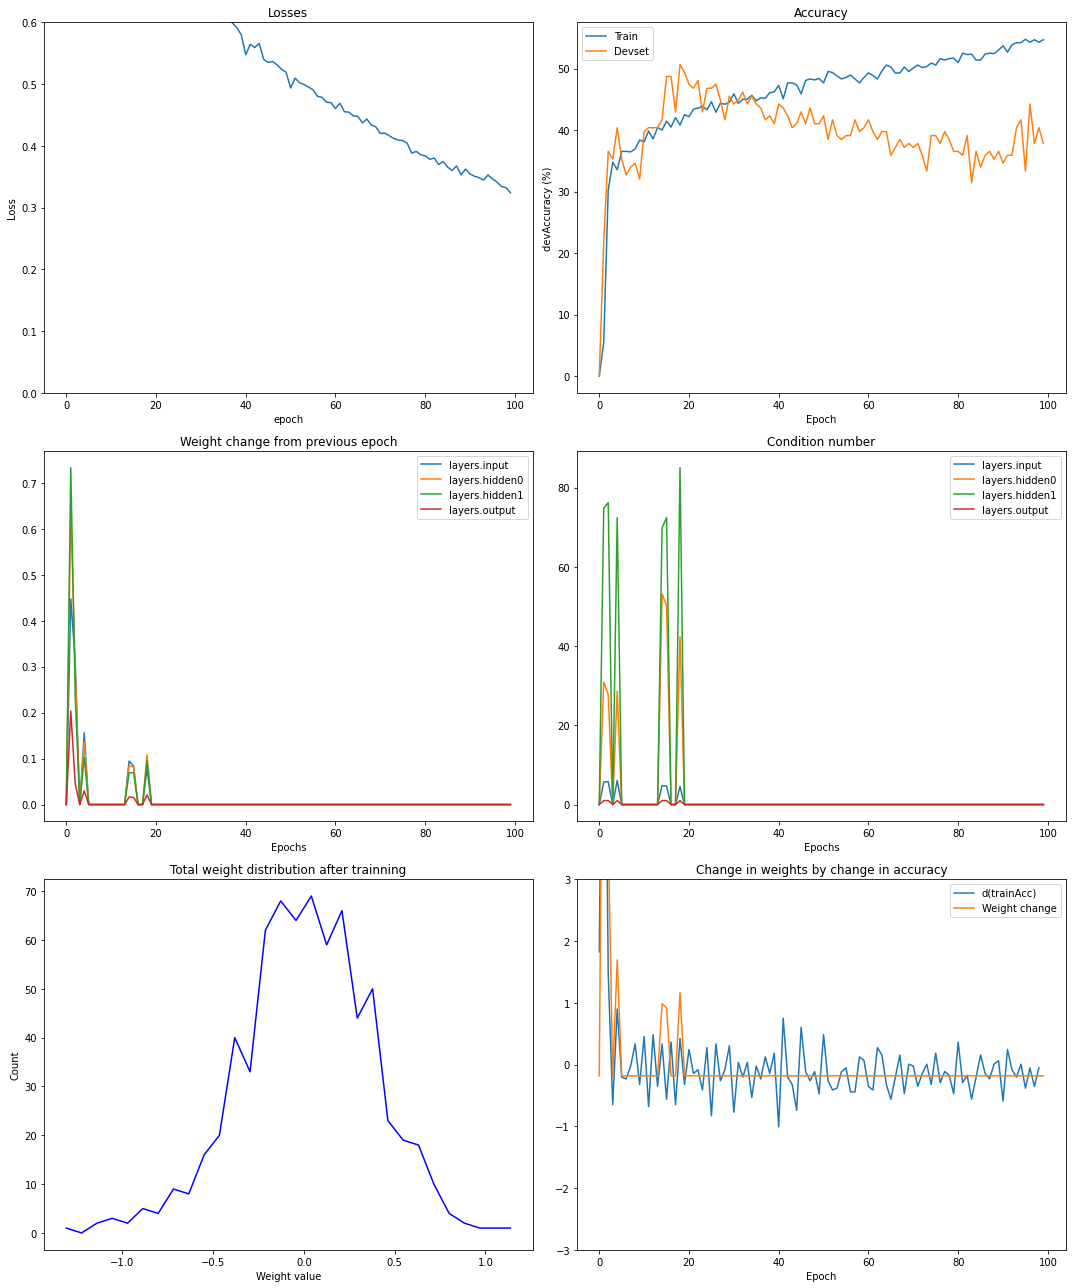

mejor
Hidden Layers:2,  Nodes in HL:16, Training Model Acc: 54.53, Best_DevAcc: 50.64, en step: 18.00, Model_test in best dev: 39.10
coef correl Test:  0.6084971047039058
Test SME:  tensor(0.0087, grad_fn=<DivBackward0>)


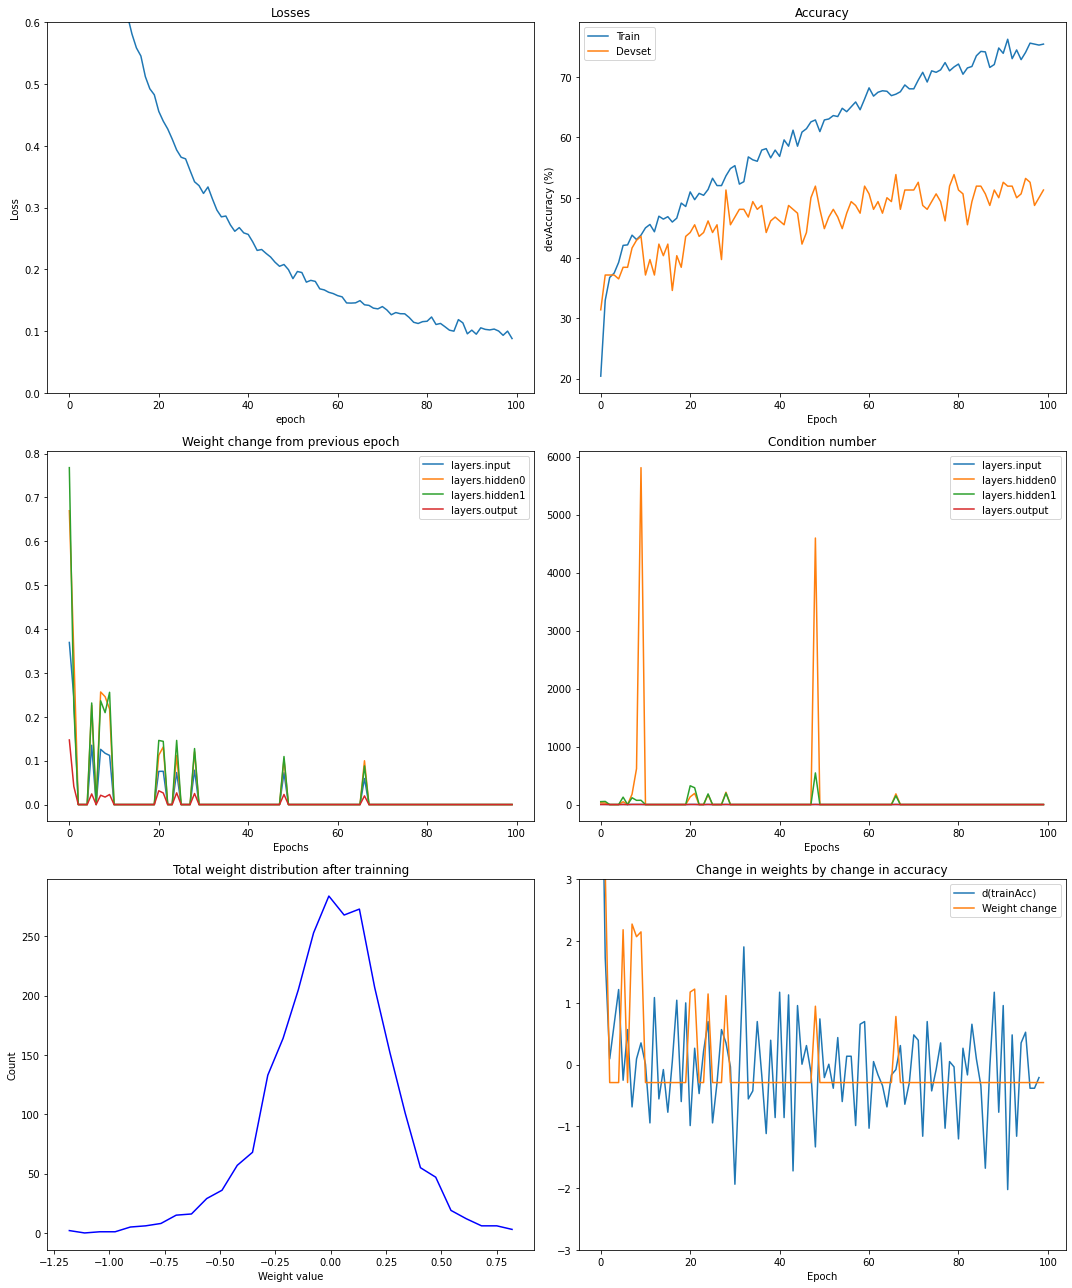

mejor
Hidden Layers:2,  Nodes in HL:32, Training Model Acc: 75.21, Best_DevAcc: 53.85, en step: 66.00, Model_test in best dev: 53.85
coef correl Test:  0.6866923624375716
Test SME:  tensor(0.0072, grad_fn=<DivBackward0>)


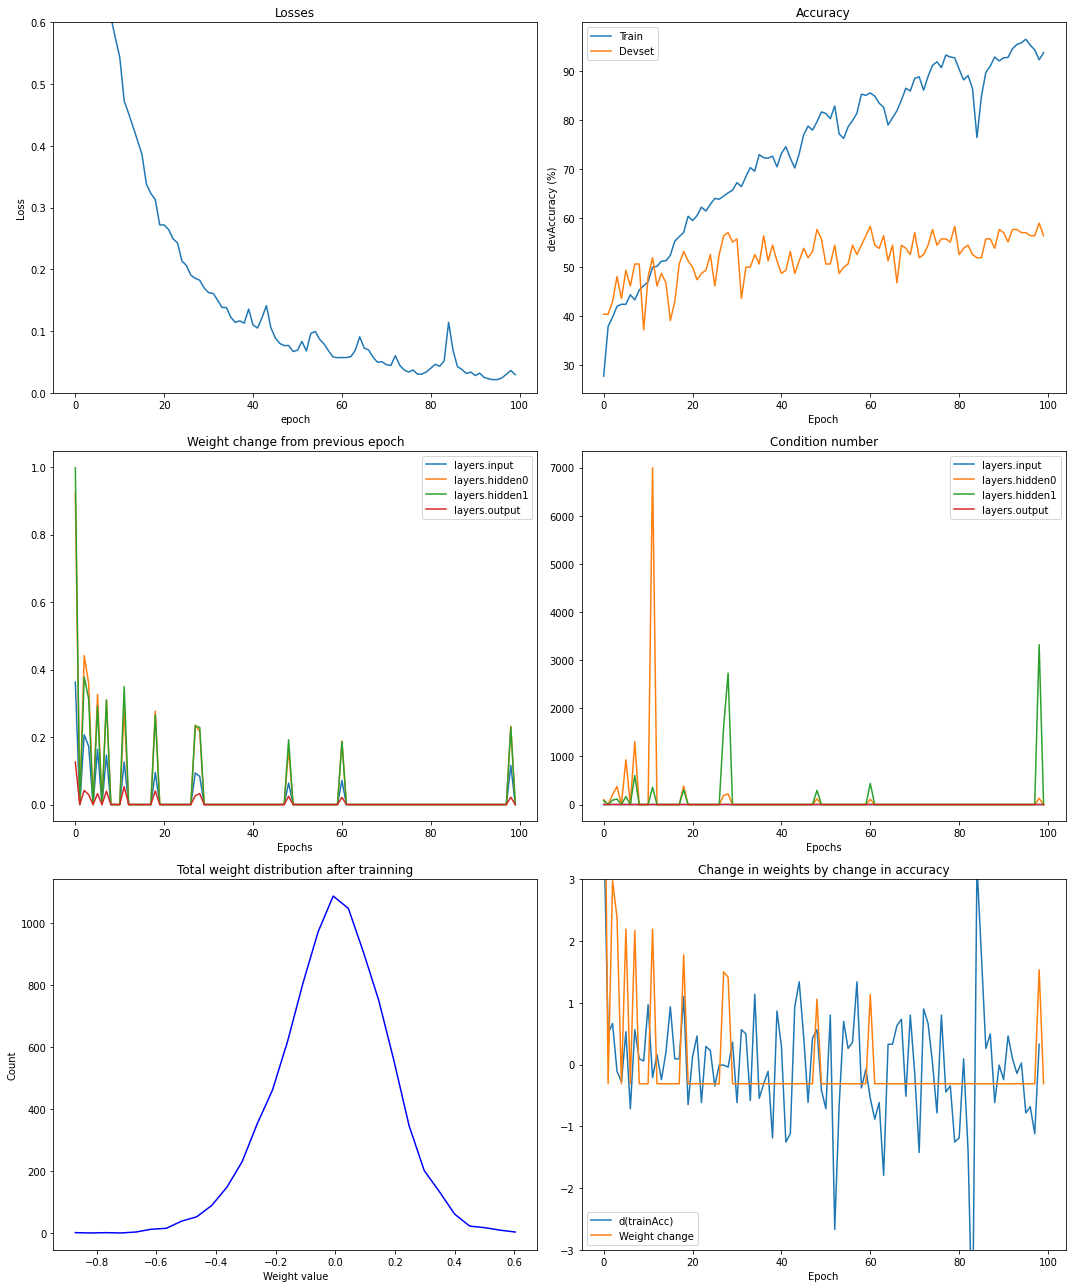

mejor
Hidden Layers:2,  Nodes in HL:64, Training Model Acc: 94.47, Best_DevAcc: 58.97, en step: 98.00, Model_test in best dev: 63.46
coef correl Test:  0.6984934292544793
Test SME:  tensor(0.0070, grad_fn=<DivBackward0>)


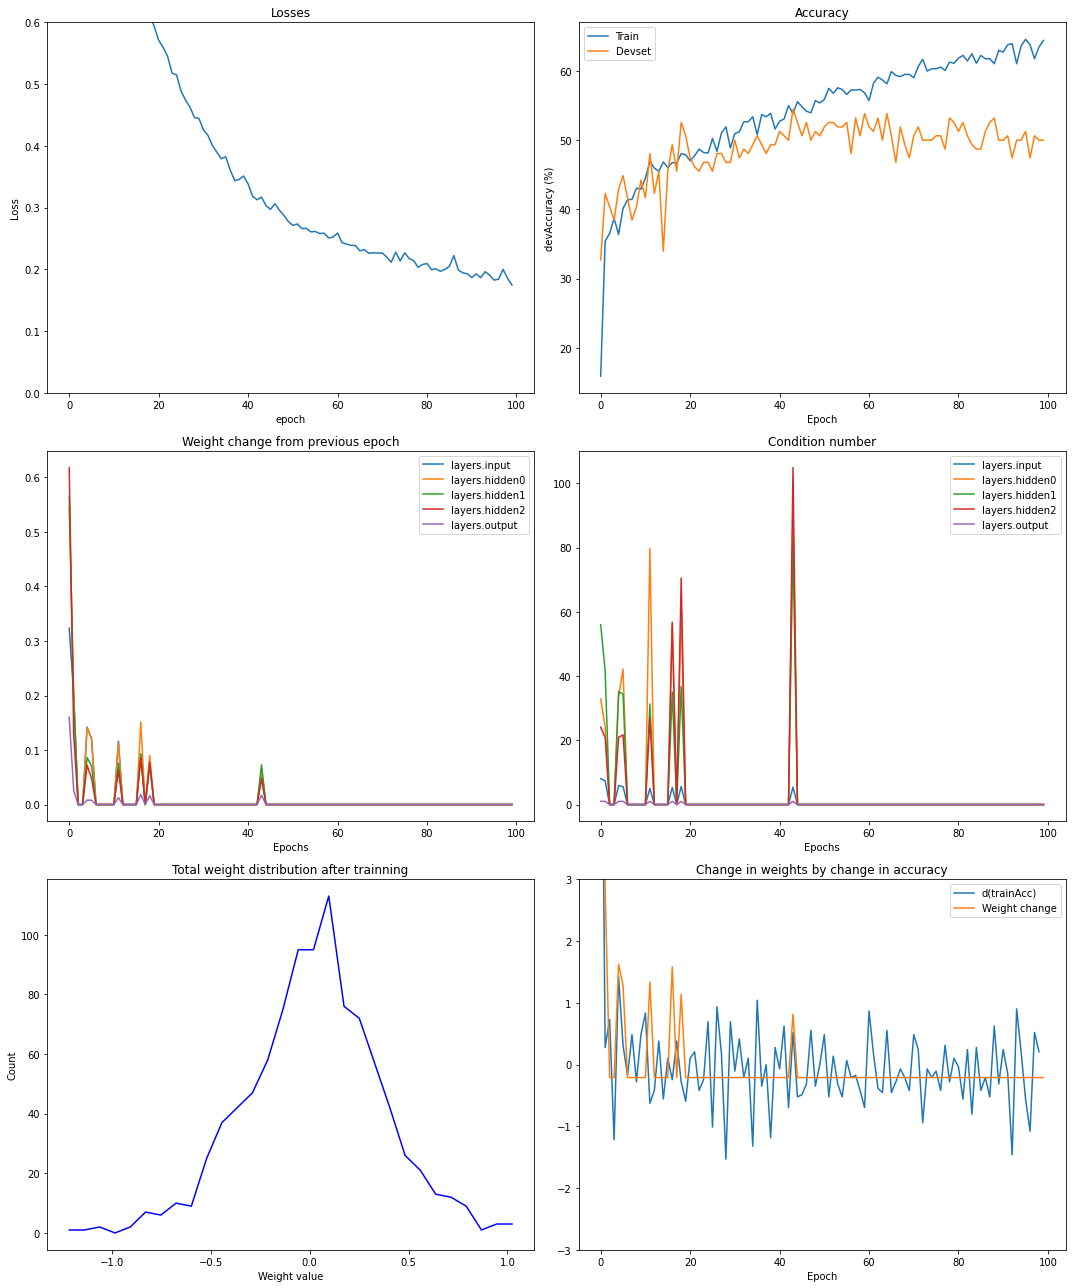

Hidden Layers:3,  Nodes in HL:16, Training Model Acc: 63.61, Best_DevAcc: 54.49, en step: 43.00, Model_test in best dev: 53.21
coef correl Test:  0.6850941632766535
Test SME:  tensor(0.0072, grad_fn=<DivBackward0>)


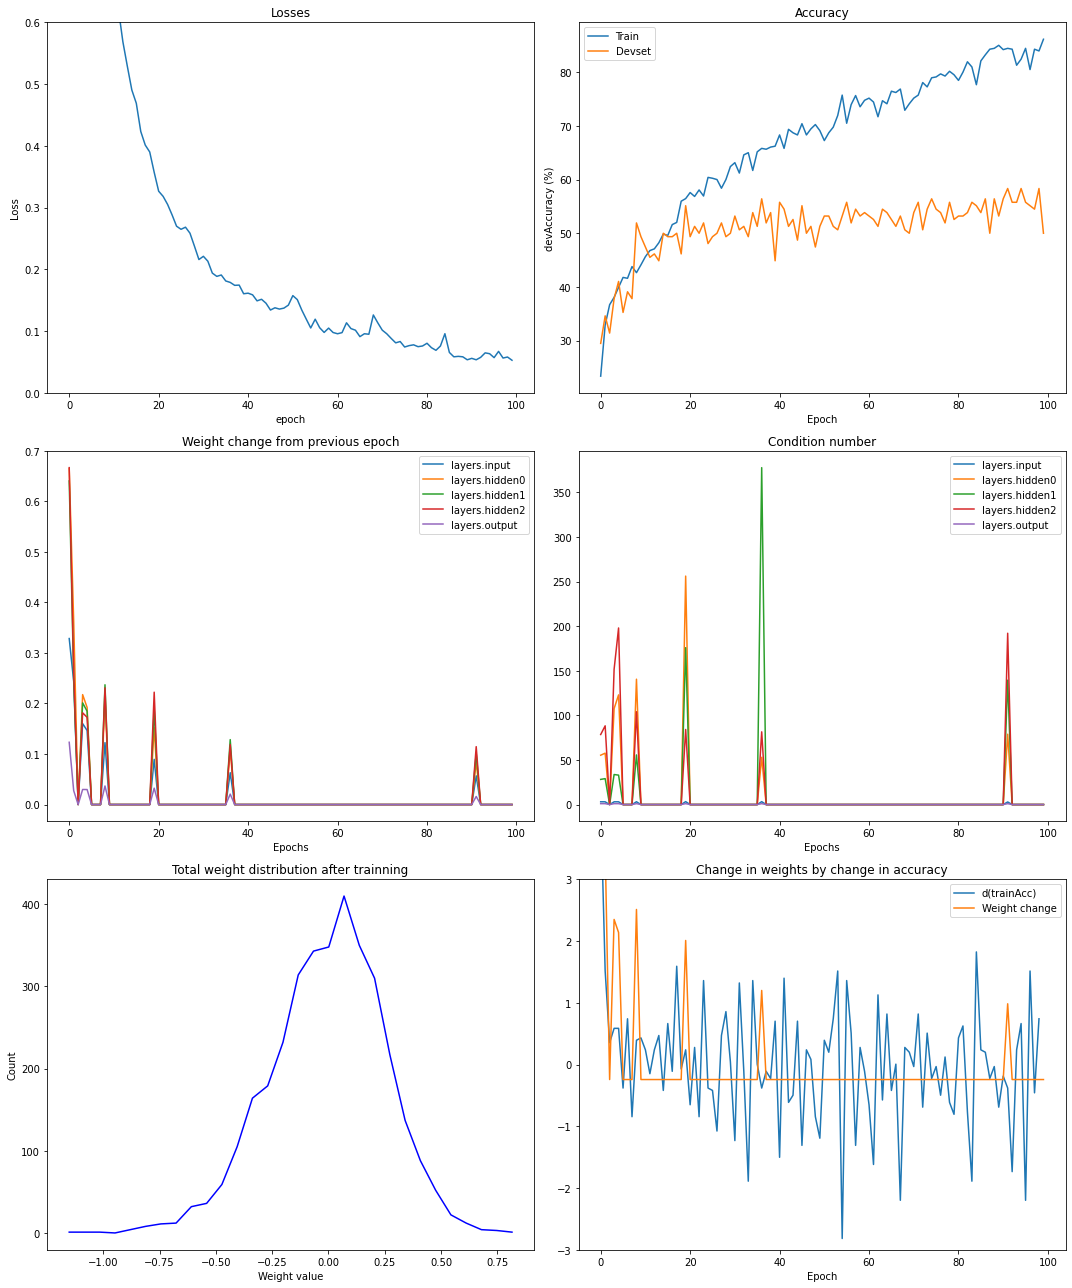

Hidden Layers:3,  Nodes in HL:32, Training Model Acc: 83.85, Best_DevAcc: 58.33, en step: 91.00, Model_test in best dev: 62.18
coef correl Test:  0.6580971663282906
Test SME:  tensor(0.0078, grad_fn=<DivBackward0>)


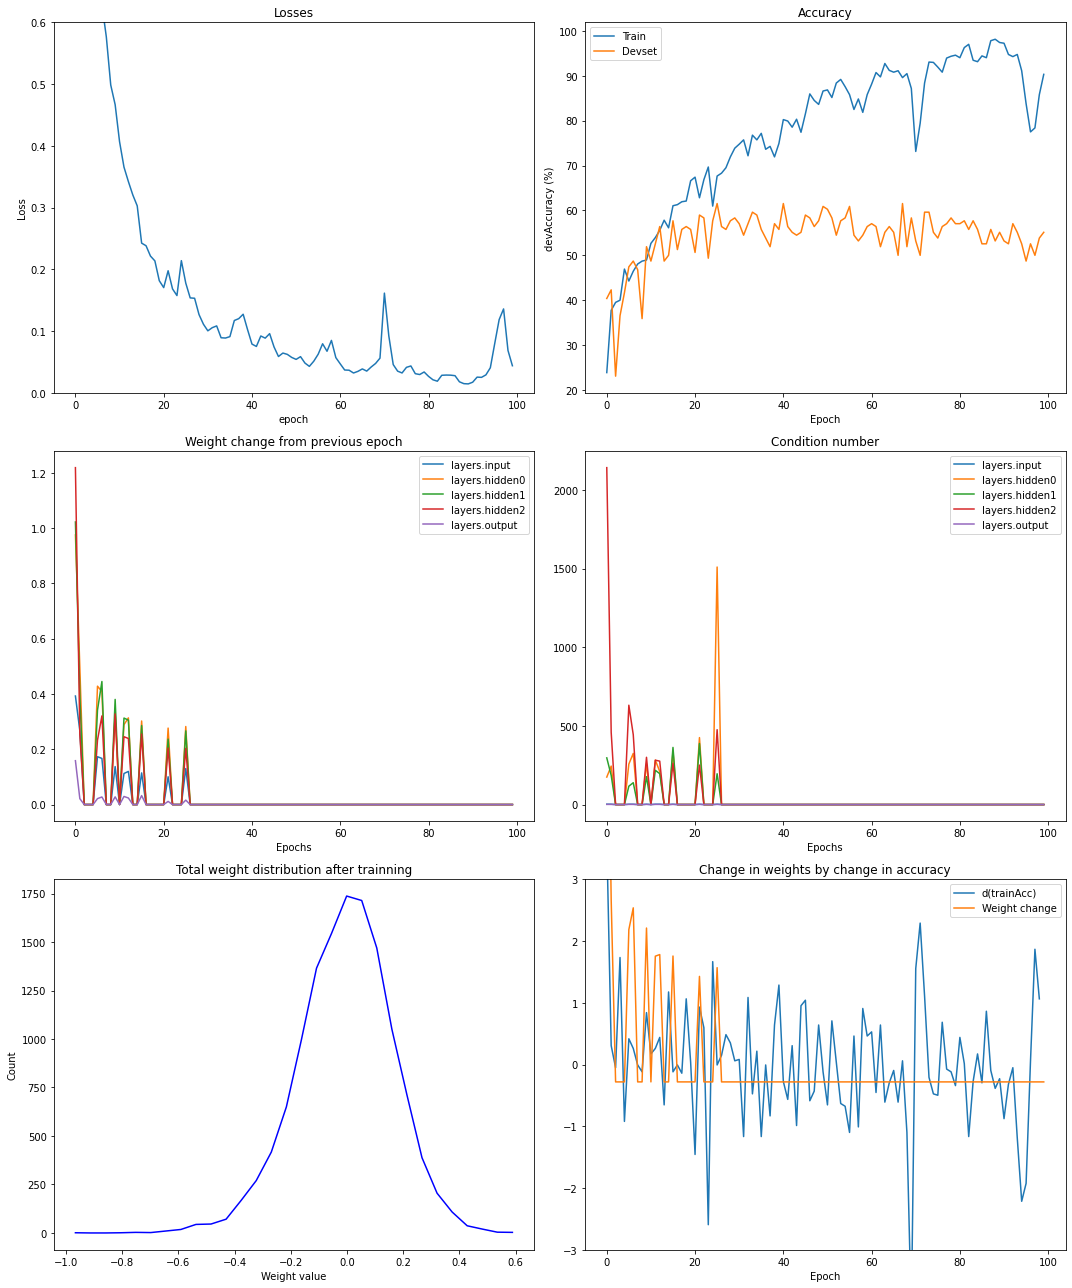

Hidden Layers:3,  Nodes in HL:64, Training Model Acc: 83.16, Best_DevAcc: 61.54, en step: 25.00, Model_test in best dev: 57.69
coef correl Test:  0.82166494453614
Test SME:  tensor(0.0044, grad_fn=<DivBackward0>)


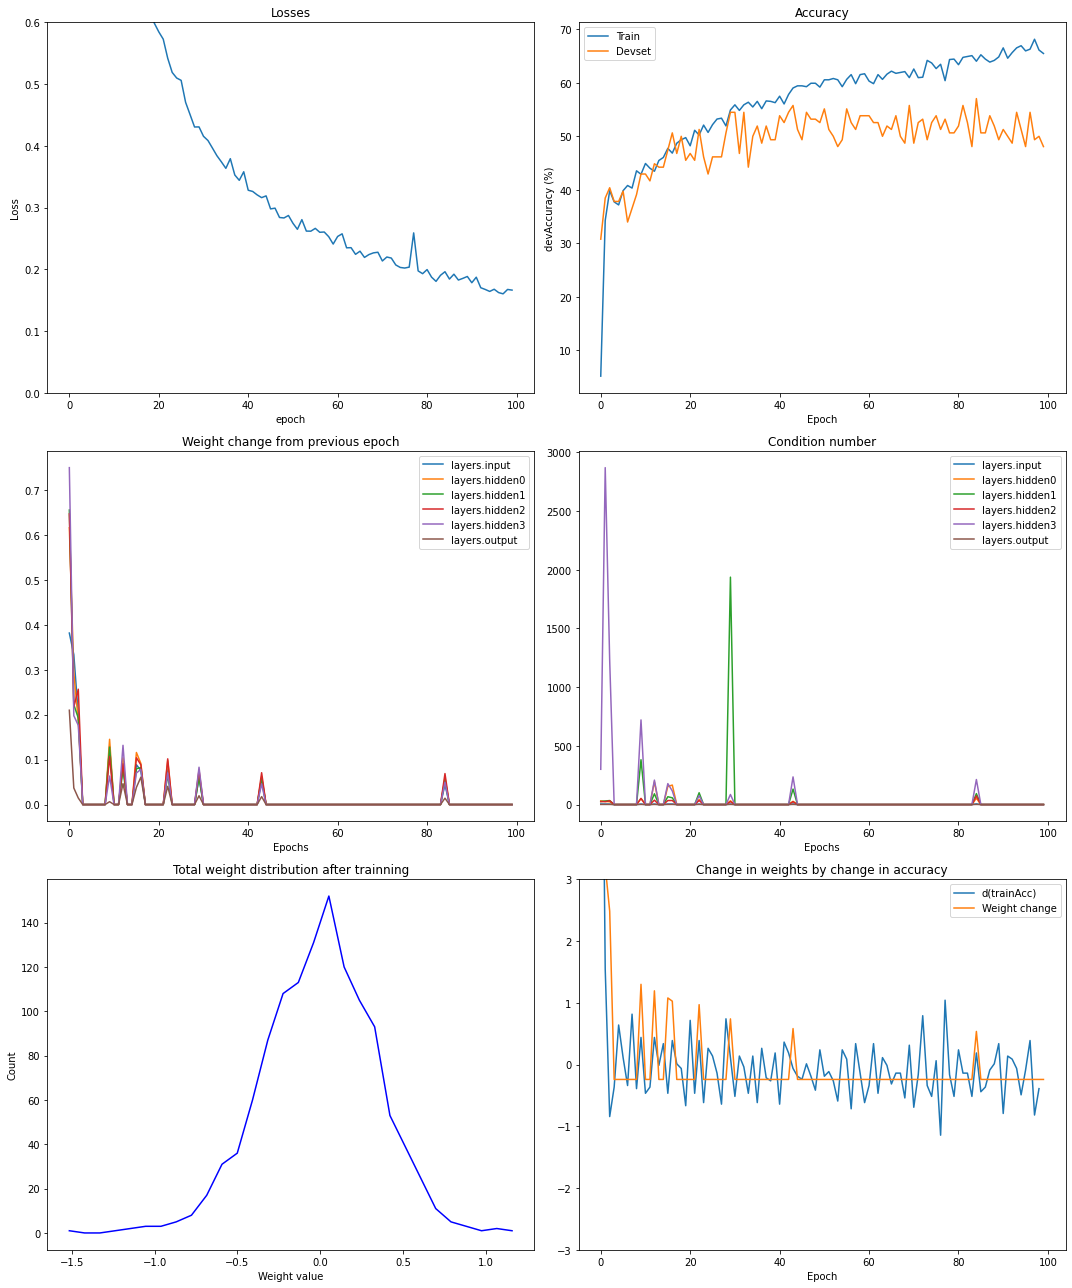

Hidden Layers:4,  Nodes in HL:16, Training Model Acc: 66.40, Best_DevAcc: 57.05, en step: 84.00, Model_test in best dev: 56.41
coef correl Test:  0.7702588433492521
Test SME:  tensor(0.0070, grad_fn=<DivBackward0>)


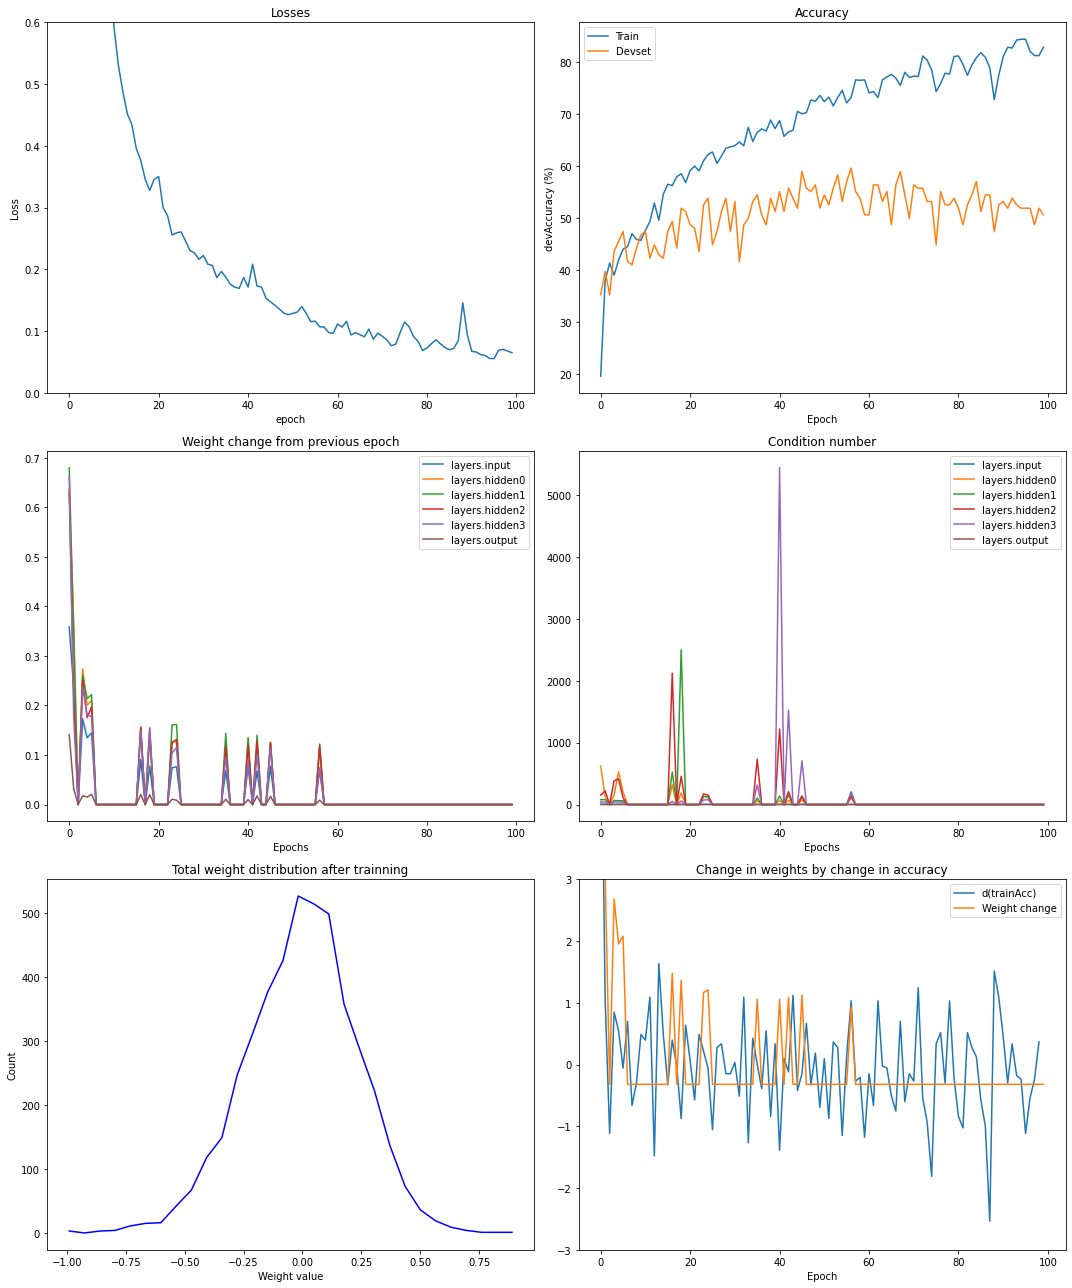

Hidden Layers:4,  Nodes in HL:32, Training Model Acc: 82.40, Best_DevAcc: 59.62, en step: 56.00, Model_test in best dev: 56.41
coef correl Test:  0.8386987179289448
Test SME:  tensor(0.0044, grad_fn=<DivBackward0>)


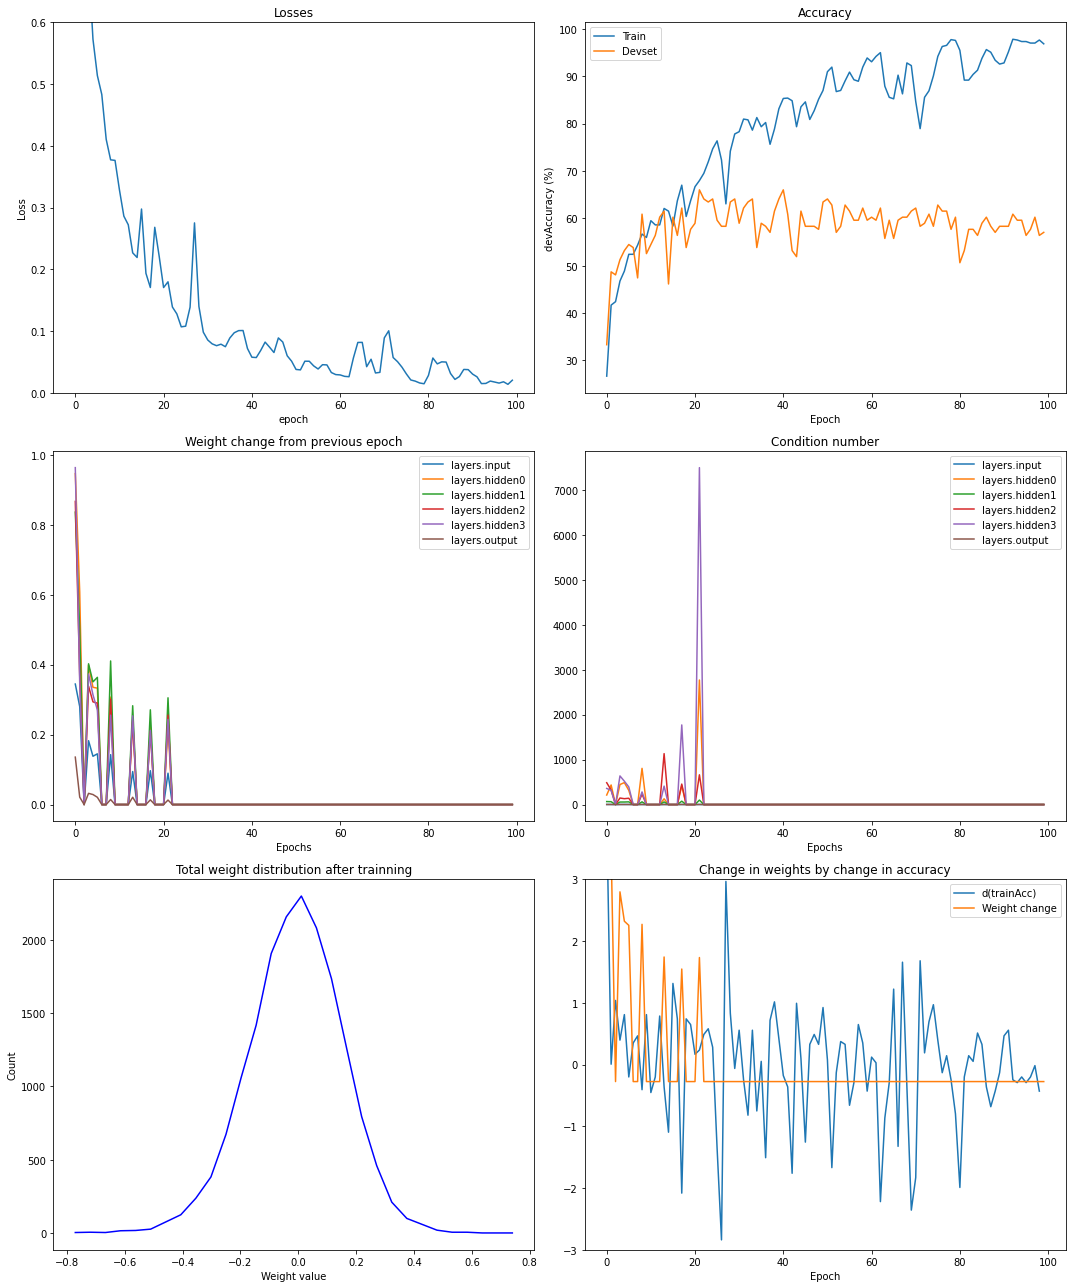

Hidden Layers:4,  Nodes in HL:64, Training Model Acc: 97.18, Best_DevAcc: 66.03, en step: 21.00, Model_test in best dev: 57.05
coef correl Test:  0.7328216353605788
Test SME:  tensor(0.0063, grad_fn=<DivBackward0>)


,HL,Hn,bestTestAcc
2,2,64,tensor(63.4615)
4,3,32,tensor(62.1795)
5,3,64,tensor(57.6923)
8,4,64,tensor(57.0513)
6,4,16,tensor(56.4103)
7,4,32,tensor(56.4103)
1,2,32,tensor(53.8462)
3,3,16,tensor(53.2051)
0,2,16,tensor(39.1026)


In [104]:

# run the model
# In this experiment, I am running the model with three variables: HIDDEN as number of Hidden layers, NHIDDEN as number of nodes in those Hidden Layers
# and in case needed, repeating each one of this cases n times just for review results consistency
# precision is a parameter used for accuracy matters to define how near we are getting the prediction.
# We also are using a bestmodel fasion where we save the best run in terms of test accuracy
# other parameters we can model are:
# splitData[0.8, 0.1] in tis case for example, we are splitting data in 80% trainning, 10% validation, and the rest (10%) testing.
# dr is the decayrate for Adam optimizer
# numephocs
# larningrate
# weigth initializer (xavier or kaming)
#

precision = 0.1 
theBestBestModel = {'devAccuracy':0, 'net':None, 'epoch':0} #net will be the whole model instance
xNum=11
labelsNum=1
HIDDEN = [2, 3, 4]
NHIDDEN = [16, 32, 64]

score={'HL':[],
    'Hn':[],
    'bestTestAcc':[]}

train_loader, dev_loader, test_loader = splitData([0.80,0.10], 20, data, labels, verbose=True )

bestBestTestAcc = 0.0

for i in range(1):
  print('\n *** set: ', i, 'cambio de conjunto de sets para trainning/dev/test')   
  
  for h in HIDDEN:
    for nh in NHIDDEN:
      n = regressionNet(nImputs=xNum, nOutputs=labelsNum, hidden=h, nHidden=nh, dr=0.0)
      trainAcc, devAcc, losses, theBestModel = n.fit(train_loader=train_loader, dev_loader=dev_loader, numepochs=100, learningRate=0.001, weight_decay=0.0001, 
                                                                       precision=precision,  initializer='xavier')
      n.drawModel()
      yHat, bestTestAcc = n.testModel(theBestModel, test_loader, precision=precision)
      if(bestBestTestAcc < bestTestAcc):
        print('mejor')
        theBestBestModel['net'] = copy.deepcopy( theBestModel['net'] ) #here update the best model
        theBestBestModel['devAccuracy'] = theBestModel['devAccuracy']
        theBestBestModel['epoch'] = theBestModel['epoch']
        bestn = copy.deepcopy(n)
        bestBestTestAcc = bestTestAcc
      print(f"Hidden Layers:{h},  Nodes in HL:{nh}, Training Model Acc: {np.mean(trainAcc[-5:]):.2f}, Best_DevAcc: {theBestModel['devAccuracy']:.2f}, en step: {theBestModel['epoch']:.2f}, Model_test in best dev: {bestTestAcc.float():.2f}")
      print('coef correl Test: ', np.corrcoef(yHat.detach().T, test_loader.dataset.tensors[1].detach().T)[1,0])
      print('Test SME: ',torch.mean(abs((yHat-test_loader.dataset.tensors[1])**2))/yHat.shape[0]  )
      score['HL'].append(h)
      score['Hn'].append(nh)
      score['bestTestAcc'].append(bestTestAcc.float())

 
score = pd.DataFrame(score)
score.sort_values(['bestTestAcc'], ascending=False)

In [105]:

n = copy.deepcopy(bestn)
yHat, bestTestAcc = n.testModel(theBestBestModel, test_loader, precision=precision)
print('The best model in terms of best Test Accuracy:: \n')
print('Hidden Layers: ', n.hidden, ' .. with size: ', n.nHidden, '.. and getting the best devAccuracy of: ', theBestBestModel['devAccuracy'] )
print('that was gotten in iteration: ', theBestBestModel['epoch'])
print('and an Accuracy Test in that epoch of:', float(bestTestAcc))
print('coef correl Test: ', np.corrcoef(yHat.detach().T, test_loader.dataset.tensors[1].detach().T)[1,0])
print('Test MSE: ',torch.mean(abs(yHat-test_loader.dataset.tensors[1])**2)/yHat.shape[0])

The best model in terms of best Test Accuracy:: 

Hidden Layers:  2  .. with size:  64 .. and getting the best devAccuracy of:  58.974361419677734
that was gotten in iteration:  98
and an Accuracy Test in that epoch of: 63.4615364074707
coef correl Test:  0.6984934292544793
Test MSE:  tensor(0.0070, grad_fn=<DivBackward0>)
